## Model for dynamic currency hedging
Hedging costs (interest rate differential) are at an All-time low now for Swiss investors. So it's much cheaper to hedge now. Should the hedge-ratio therefore increase?

Do an empirical analysis and find out whether hedging costs are a good indicator for future currency returns. My thesis: When hedging costs are low, future FX returns are actually positive (because of mean-reversion) and therefore increasing hedging when costs are low is not optimal.

Do valuations of currencies play a role in hedging? Do an empirical analysis and find out whether hedging expensive currencies and not hedging cheap currencies was a good strategy.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

#### Hedging cost as indicator for future currency returns

In [18]:
# Need FX and interest rates
currencies = "Data/FX_CHF_ALL_1971-2020.xlsx"
interest_rates = "Data/3M_interest_rates.xlsx"

# FX
df_fx_indirect = pd.read_excel(currencies, header=0, index_col=0, sheet_name="Sheet1")
df_fx_direct = 1 / df_fx_indirect
df_fx_direct = df_fx_direct.replace([np.inf, -np.inf], np.nan)
df_fx_direct.columns = ['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']

# Interest rates
df_r = pd.read_excel(interest_rates, header=1, index_col=0)
df_r.columns = ['CHF', 'USD', 'EUR', 'GBP', 'JPY', 'CAD', 'AUD']
df_r = df_r/100
df_r = df_r[df_r!=0].dropna()

# Do analysis based on monthly data

# FX
df_fx_direct_m = df_fx_direct.resample('M').last()
df_fx_direct_m = df_fx_direct_m[df_fx_direct_m!=0].dropna()

# Interest rates
df_r_m = df_r.resample('M').last()
df_r_m = df_r_m[df_r_m!=0].dropna()

# Only keep data of common dates
index_intersection = df_r_m.index.intersection(df_fx_direct_m.index)
df_fx_direct_m = df_fx_direct_m.loc[index_intersection]
df_r_m = df_r_m.loc[index_intersection]


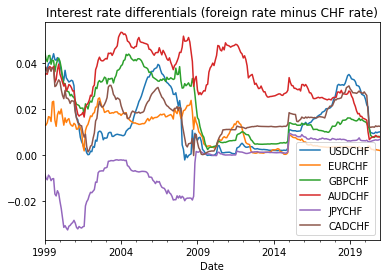

In [19]:
# Get interest rate differentials for currency pairs. Base currency is CHF, so foreign interest rate minus CHF rate
df_r_diff = pd.DataFrame(columns = df_fx_direct_m.columns, index = df_fx_direct_m.index)
df_r_diff['USDCHF'] = df_r_m['USD'] - df_r_m['CHF']
df_r_diff['EURCHF'] = df_r_m['EUR'] - df_r_m['CHF']
df_r_diff['GBPCHF'] = df_r_m['GBP'] - df_r_m['CHF']
df_r_diff['AUDCHF'] = df_r_m['AUD'] - df_r_m['CHF']
df_r_diff['JPYCHF'] = df_r_m['JPY'] - df_r_m['CHF']
df_r_diff['CADCHF'] = df_r_m['CAD'] - df_r_m['CHF']

df_r_diff.plot()
plt.title('Interest rate differentials (foreign rate minus CHF rate)')
plt.savefig('Plots/InterestRateDifferentials.jpg', dpi=300)



1 month ahead fx returns


Intercept   -0.025896
x            1.434214
dtype: float64
RSquared: 0.004


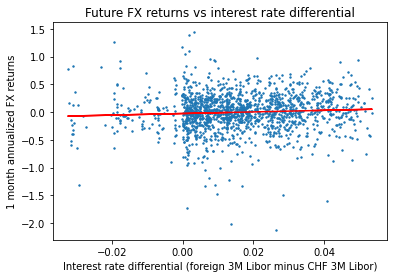



2 month ahead fx returns


Intercept   -0.026014
x            1.434676
dtype: float64
RSquared: 0.01


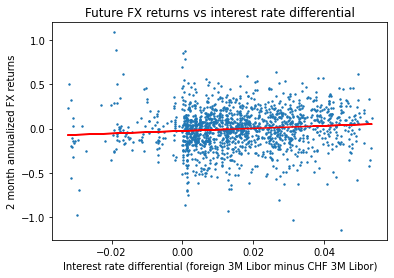



3 month ahead fx returns


Intercept   -0.025845
x            1.386582
dtype: float64
RSquared: 0.014


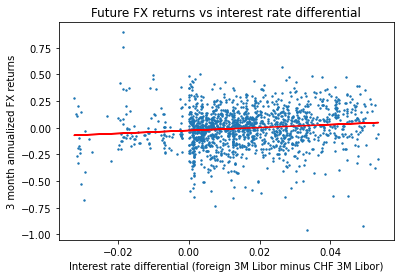



6 month ahead fx returns


Intercept   -0.027003
x            1.367418
dtype: float64
RSquared: 0.029


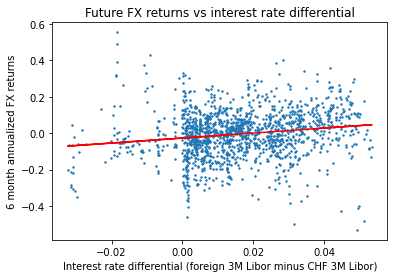



12 month ahead fx returns


Intercept   -0.029621
x            1.441740
dtype: float64
RSquared: 0.068


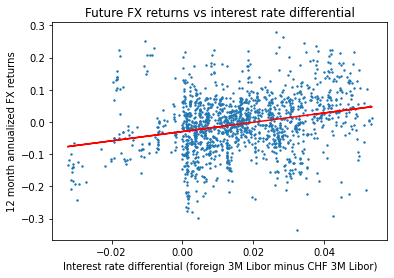



18 month ahead fx returns


Intercept   -0.029773
x            1.387665
dtype: float64
RSquared: 0.108


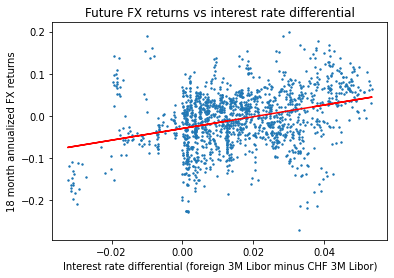



24 month ahead fx returns


Intercept   -0.027854
x            1.244484
dtype: float64
RSquared: 0.125


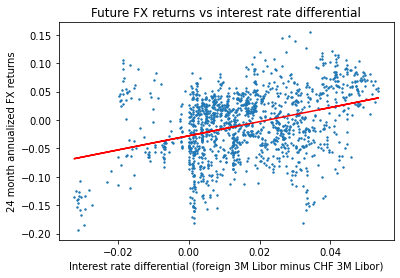



36 month ahead fx returns


Intercept   -0.024565
x            1.029553
dtype: float64
RSquared: 0.137


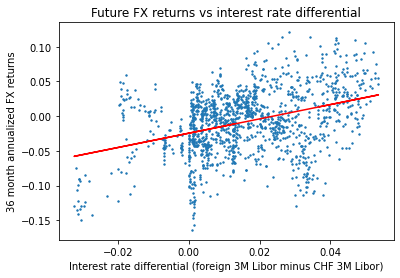

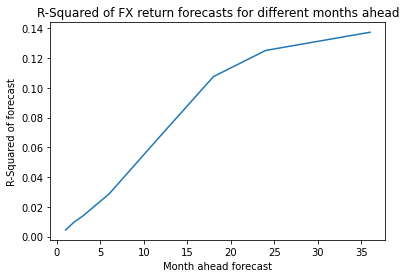

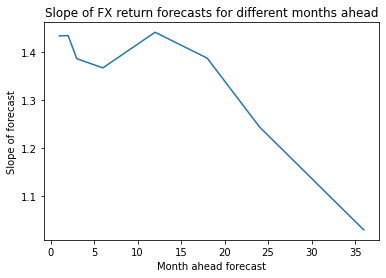

,1,2,3,6,12,18,24,36
intercept,-0.025896,-0.026014,-0.025845,-0.027003,-0.029621,-0.029773,-0.027854,-0.024565
p-value intercept,0.046883,0.003712,0.000334,0.000000,0.000000,0.000000,0.000000,0.000000
slope,1.434214,1.434676,1.386582,1.367418,1.441740,1.387665,1.244484,1.029553
p-value slope,0.015054,0.000535,0.000049,0.000000,0.000000,0.000000,0.000000,0.000000
RSquared,0.004437,0.009856,0.013919,0.028691,0.068371,0.107640,0.125222,0.137465


In [20]:
# Get future currency returns

# Function to get forward rates
def fx_forward(currency_pair, t, t_1, fx, interest_rates):
    """Useage:
    date_1 = pd.Timestamp('2020-12-16')
    date_2 = pd.Timestamp('2020-12-18')
    fx_forward('USDCHF', date_1, date_2, df_fx, df_r)
    """
    # Get spot exchange rate and LIBOR rates. r_d: domestic, r_f: foreign
    s = fx.loc[t, currency_pair]
    r_d = interest_rates.loc[t, currency_pair[3:]]
    r_f = interest_rates.loc[t, currency_pair[:3]]
    
    # Calculate number of days
    n_days = t_1 - t
    n_days = n_days.days
    
    # Formula as in FORWARD AND SPOT EXCHANGE RATES*, FAMA 1984, Equation 9
    
    # Forward rate
    f = np.log(s) + np.log(1+r_d)*n_days/365 - np.log(1+r_f)*n_days/365
    
    return np.exp(f)


# N month ahead exchange rate forecasting
forecast_durations = [1,2,3,6,12,18,24,36]

# To store result
fx_forecast = pd.DataFrame(columns=['intercept', 'p-value intercept', 'slope','p-value slope', 'RSquared'], index=forecast_durations)

# Create forecasts for every duration
for n in forecast_durations:

    # Create a df with monthly forward rates
    df_f_m = pd.DataFrame(index=df_r_diff.index, columns=df_r_diff.columns)
    df_f_m = df_f_m.sort_index()
    for d in range(len(df_f_m.index)-n):
        for c in range(len(df_f_m.columns)):
            try:
                df_f_m.iloc[d, c] = fx_forward(df_f_m.columns[c], df_f_m.index[d], df_f_m.index[d+n], df_fx_direct_m, df_r_m)
            except KeyError:
                print(d)
                df_f_m.iloc[d, c] = np.nan

    # Future FX returns are log(future spot rate) - log(forward rate)
    # Somehow np.log(df_f_m) gives an error
    df_f_m_log = df_f_m.copy()
    for c in df_f_m_log.columns:
        for i in df_f_m_log.index:
            df_f_m_log.loc[i,c] = np.log(df_f_m.loc[i,c])
    df_future_fx_ret = np.log(df_fx_direct_m.shift(-n)) - df_f_m_log
    
    # Annualize the returns, for comparison of the betas
    df_future_fx_ret = 12 * df_future_fx_ret / n

    # First individual currencies
#     for c in df_future_fx_ret.columns:
#         print(c)
#         x = df_r_diff[c]
#         y = df_future_fx_ret[c]
#         df = pd.DataFrame({'x':pd.to_numeric(x), 'y':pd.to_numeric(y)})
#         df = df[df!=0].dropna()
#         mod = ols('y ~ x', data=df).fit()
#         if mod.rsquared > 0.00:
#             print(n)
#             print(c)
#             plt.scatter(df_r_diff[c], df_future_fx_ret[c])
#             plt.show()
#             print(mod.params)
#             print(mod.rsquared)
    
    # Now all currencies
    x = df_r_diff.unstack()
    y = df_future_fx_ret.unstack()
    df = pd.DataFrame({'x':pd.to_numeric(x), 'y':pd.to_numeric(y)})
    df = df[df!=0].dropna()
    mod = ols('y ~ x', data=df).fit(cov_type='HC3')
    
    # Print some info
    print('\n')
    print(str(n) + ' month ahead fx returns')
    print('\n')
    print(mod.params)
    print('RSquared: ' + str(round(mod.rsquared,3 )))
    
    # Store info in df
    fx_forecast.loc[n, 'intercept'] = mod.params['Intercept']
    fx_forecast.loc[n, 'slope'] = mod.params['x']
    fx_forecast.loc[n, 'p-value intercept'] = mod.pvalues[0]
    fx_forecast.loc[n, 'p-value slope'] = mod.pvalues[1]
    fx_forecast.loc[n, 'RSquared'] = mod.rsquared
    
    # Scatter plot
    plt.scatter(x, y, s=2)
    plt.plot(x.values ,mod.params['Intercept'] + mod.params['x']*x.values,"r")
    plt.title('Future FX returns vs interest rate differential')
    plt.xlabel('Interest rate differential (foreign 3M Libor minus CHF 3M Libor)')
    plt.ylabel(str(n) + ' month annualized FX returns')
    plt.savefig('Plots/' + str(n) + 'MonthAheadFXReturnsVsInterestDifferential.jpg', dpi=300)
    plt.show()
    

# Plot to visualize RSquared
fx_forecast['RSquared'].plot()
plt.title('R-Squared of FX return forecasts for different months ahead')
plt.xlabel('Month ahead forecast')
plt.ylabel('R-Squared of forecast')
plt.savefig('Plots/FXForecastRSquared.jpg')
plt.show()

# Plot to visualize slope of regressions
fx_forecast['slope'].plot()
plt.title('Slope of FX return forecasts for different months ahead')
plt.xlabel('Month ahead forecast')
plt.ylabel('Slope of forecast')
plt.savefig('Plots/FXForecastSlopes.jpg')
plt.show()

# Summary of forecasts
fx_forecast.transpose()

#### Outcome
When hedging, meaning to go short the foreign currency, you take a loan in the foreign currency and invest it in CHF. Therefore the differential, or the hedging cost are foreign interest rate minus CHF interest rate. From the scatter plot we can see that if the differential is high, a long position in the fx will create positive returns. However, when hedging you take a short position in the foreign currency, meaning that if the differential is high the short position will have negative returns. 

Therefore you should not hedge when the differential is high, but you should hedge when the differential is low and hedging cost are low.

### Currency valuations
Do valuations of currencies play a role in hedging? Do an empirical analysis and find out whether hedging expensive currencies and not hedging cheap currencies was a good strategy.

Expensive currency = strength > 0 ?

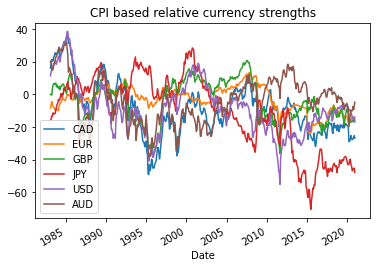

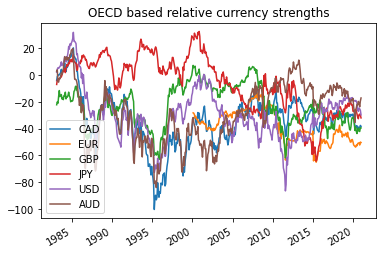

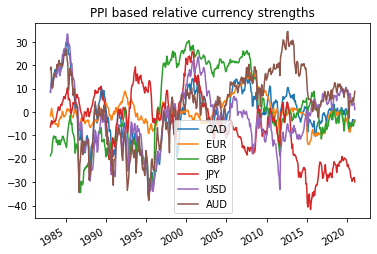

In [21]:
# FX and interest rate data are already loaded

# Unhedged MSCI World denoted in CHF
msci_world_total_return_chf = "Data/MSCI_World_total_return_chf.xlsx"
df_msci_world_chf = pd.read_excel(msci_world_total_return_chf, header=18, index_col=0)
df_msci_world_chf_m = df_msci_world_chf['Close'].dropna().sort_index().resample('M').last()

# Fully CHF hedged MSCI World
msci_world_total_return_h_chf = "Data/Msci World hCHF.xlsx"
df_msci_world_h_chf = pd.read_excel(msci_world_total_return_h_chf, header=0, index_col=0)
df_msci_world_h_chf_m = df_msci_world_h_chf.dropna().sort_index().resample('M').last()

# Relative Currency strength data
rel_currency_strength = "Data/CHF_RELATIVE_ALL.xlsx"
df_rel_currency_strength_cpi = pd.read_excel(rel_currency_strength, header = 0, index_col = 0, sheet_name='CPI', parse_dates=True)
df_rel_currency_strength_cpi.plot()
plt.title('CPI based relative currency strengths')
plt.show()

df_rel_currency_strength_oecd = pd.read_excel(rel_currency_strength, header = 0, index_col = 0, sheet_name='OECD', parse_dates=True)
df_rel_currency_strength_oecd.plot()
plt.title('OECD based relative currency strengths')
plt.show()

df_rel_currency_strength_ppi = pd.read_excel(rel_currency_strength, header = 0, index_col = 0, sheet_name='PPI', parse_dates=True)
df_rel_currency_strength_ppi.plot()
plt.title('PPI based relative currency strengths')
plt.show()

# Currency weights from task 2
currency_weights = 'MSCIWorldCurrencyWeights.csv'
df_currency_weights = pd.read_csv(currency_weights, index_col=0, parse_dates=True)
df_currency_weights = df_currency_weights[df_currency_weights.sum(axis=1)!=0].dropna()
df_currency_weights = df_currency_weights.resample('M').last()


Follow task 2 in creating df of assets

In [22]:
# Prepare data to build the hedged portfolio

# We can ignore fx forward margin according to Nicola Grass. Therefore set it to 0.
backtest_fx_margin = 0

# All months included in the backtest
months = df_msci_world_chf_m.index
backtest_start = '2002-12-31'
months = months[months >= backtest_start]

# Dataframe of all assets that can be invested in

# Create a df with monthly forward rates
df_f_m = pd.DataFrame(index=df_fx_direct_m.index, columns=df_fx_direct_m.columns)
df_f_m = df_f_m.sort_index()
for d in range(len(df_f_m.index)-1):
    for c in range(len(df_f_m.columns)):
        try:
            df_f_m.iloc[d, c] = fx_forward(df_f_m.columns[c], df_f_m.index[d], df_f_m.index[d+1], df_fx_direct_m, df_r_m)
        except KeyError:
            df_f_m.iloc[d, c] = np.nan

# First FX positions. FX return is the log(spot rate of time t) - log(forward rate of t-1)
log_fx_direct = df_fx_direct_m.copy()
log_df_f = df_f_m.copy()

for r in log_fx_direct.index:
    for c in log_fx_direct.columns:
        log_fx_direct.loc[r,c] = np.log(df_fx_direct_m.loc[r,c])
for r in log_df_f.index:
    for c in log_df_f.columns:
        log_df_f.loc[r,c] = np.log(df_f_m.loc[r,c])

backtest_asset_returns = log_fx_direct - log_df_f.shift()

# Add MSCI World total return index
backtest_asset_returns['MSCI World'] = np.log(df_msci_world_chf_m).diff()

# Only relevant months
backtest_asset_returns = backtest_asset_returns.loc[months,:]

# Note that these returns are log returns, but they need to be simple returns to calculate cross section 
# portfolio returns
# backtest_asset_returns = np.exp(backtest_asset_returns) - 1 ### Somehow this gives me an error, therefore use
# inefficient method below
for r in backtest_asset_returns.index:
    for c in backtest_asset_returns.columns:
        backtest_asset_returns.loc[r,c] = np.exp(backtest_asset_returns.loc[r,c]) - 1
backtest_asset_returns

,USDCHF,EURCHF,GBPCHF,AUDCHF,JPYCHF,CADCHF,MSCI World
Exchange Date,,,,,,,
2002-12-31,-0.066687,-0.013694,-0.033217,-0.062554,-0.038401,-0.069785,-0.113865
2003-01-31,-0.013413,0.013185,0.011843,0.034072,-0.024107,0.022182,-0.042809
2003-02-28,-0.007821,-0.003688,-0.051195,0.030892,0.006475,0.016736,-0.025140
2003-03-31,-0.000030,0.011370,0.008596,-0.003658,-0.000708,0.012710,-0.005732
2003-04-30,0.003228,0.028586,0.015075,0.042763,-0.004608,0.031562,0.092571
...,...,...,...,...,...,...,...
2020-08-31,-0.009680,0.003675,0.012158,0.022836,-0.010375,0.018666,0.056061
2020-09-30,0.019778,0.000715,-0.014357,-0.009891,0.023732,-0.000790,-0.016119
2020-10-31,-0.003449,-0.010246,-0.001659,-0.022153,0.004128,-0.003385,-0.034886


In [23]:
# Now determine the portfolio weights

# Empty df to store asset weights
backtest_expensive_hedge_weights_cpi = pd.DataFrame(0, index=months, columns=backtest_asset_returns.columns)
backtest_expensive_hedge_weights_ppi = pd.DataFrame(0, index=months, columns=backtest_asset_returns.columns)
backtest_expensive_hedge_weights_oecd = pd.DataFrame(0, index=months, columns=backtest_asset_returns.columns)
backtest_expensive_hedge_weights_check = pd.DataFrame(0, index=months, columns=backtest_asset_returns.columns)

# MSCI World investment is always 1
backtest_expensive_hedge_weights_cpi['MSCI World'] = 1
backtest_expensive_hedge_weights_ppi['MSCI World'] = 1
backtest_expensive_hedge_weights_oecd['MSCI World'] = 1
backtest_expensive_hedge_weights_check['MSCI World'] = 1

# Order currency weight df
df_currency_weights = df_currency_weights[['USD', 'EUR', 'GBP', 'AUD', 'JPY', 'CAD']]

# To hedge means to be short
df_currency_hedge_weights_cpi = -df_currency_weights
df_currency_hedge_weights_ppi = -df_currency_weights
df_currency_hedge_weights_oecd = -df_currency_weights
df_currency_hedge_weights_check = -df_currency_weights

# Now only hedge expensive currencies, no not hedge cheap ones (strength < 0)

# First create same order, and index
df_rel_currency_strength_cpi = df_rel_currency_strength_cpi[['USD', 'EUR', 'GBP', 'AUD', 'JPY', 'CAD']]
df_rel_currency_strength_cpi = df_rel_currency_strength_cpi.resample('M').last()
df_rel_currency_strength_cpi = df_rel_currency_strength_cpi.loc[df_currency_hedge_weights_cpi.index, :]

df_rel_currency_strength_ppi = df_rel_currency_strength_ppi[['USD', 'EUR', 'GBP', 'AUD', 'JPY', 'CAD']]
df_rel_currency_strength_ppi = df_rel_currency_strength_ppi.resample('M').last()
df_rel_currency_strength_ppi = df_rel_currency_strength_ppi.loc[df_currency_hedge_weights_ppi.index, :]

df_rel_currency_strength_oecd = df_rel_currency_strength_oecd[['USD', 'EUR', 'GBP', 'AUD', 'JPY', 'CAD']]
df_rel_currency_strength_oecd = df_rel_currency_strength_oecd.resample('M').last()
df_rel_currency_strength_oecd = df_rel_currency_strength_oecd.loc[df_currency_hedge_weights_oecd.index, :]

# Weights are 0 where strength < 0
df_currency_hedge_weights_cpi[df_rel_currency_strength_cpi < 0] = 0
df_currency_hedge_weights_ppi[df_rel_currency_strength_ppi < 0] = 0
df_currency_hedge_weights_oecd[df_rel_currency_strength_oecd < 0] = 0

# Insert into other df
backtest_expensive_hedge_weights_cpi[['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']] = df_currency_hedge_weights_cpi
backtest_expensive_hedge_weights_ppi[['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']] = df_currency_hedge_weights_ppi
backtest_expensive_hedge_weights_oecd[['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']] = df_currency_hedge_weights_oecd
backtest_expensive_hedge_weights_check[['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']] = df_currency_hedge_weights_check




In [24]:
# Determine partially hedged MSCI World returns

# Returns are weights of previous period * return of asset
backtest_expensive_hedge_returns_cpi = backtest_expensive_hedge_weights_cpi.shift(1) * backtest_asset_returns
backtest_expensive_hedge_returns_cpi = backtest_expensive_hedge_returns_cpi.sum(axis=1)

backtest_expensive_hedge_returns_ppi = backtest_expensive_hedge_weights_ppi.shift(1) * backtest_asset_returns
backtest_expensive_hedge_returns_ppi = backtest_expensive_hedge_returns_ppi.sum(axis=1)

backtest_expensive_hedge_returns_oecd = backtest_expensive_hedge_weights_oecd.shift(1) * backtest_asset_returns
backtest_expensive_hedge_returns_oecd = backtest_expensive_hedge_returns_oecd.sum(axis=1)

backtest_expensive_hedge_returns_check = backtest_expensive_hedge_weights_check.shift(1) * backtest_asset_returns
backtest_expensive_hedge_returns_check = backtest_expensive_hedge_returns_check.sum(axis=1)

# Change back to log returns to aggregate over time
backtest_expensive_hedge_returns_cpi = np.log(1+backtest_expensive_hedge_returns_cpi)
backtest_expensive_hedge_returns_ppi = np.log(1+backtest_expensive_hedge_returns_ppi)
backtest_expensive_hedge_returns_oecd = np.log(1+backtest_expensive_hedge_returns_oecd)
backtest_expensive_hedge_returns_check = np.log(1+backtest_expensive_hedge_returns_check)

# Create index by multiplying 100 with 1 + simple return over time???
backtest_expensive_hedge_cpi = 100*(np.exp(backtest_expensive_hedge_returns_cpi.cumsum()))
backtest_expensive_hedge_ppi = 100*(np.exp(backtest_expensive_hedge_returns_ppi.cumsum()))
backtest_expensive_hedge_oecd = 100*(np.exp(backtest_expensive_hedge_returns_oecd.cumsum()))
backtest_expensive_hedge_check = 100*(np.exp(backtest_expensive_hedge_returns_check.cumsum()))

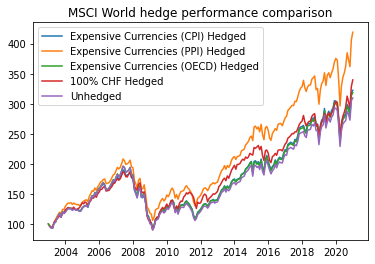

In [25]:
# Compare with 100% CHF hedged MSCI World
backtest_benchmark_hedged_msci_world_returns = np.log(df_msci_world_h_chf_m['M0WOHCHF Index'].loc[backtest_expensive_hedge_cpi.index]).diff()
backtest_benchmark_hedged_msci_world = 100*(np.exp(backtest_benchmark_hedged_msci_world_returns.cumsum()))

# Compare with unhedged MSCI World
backtest_benchmark_unhedged_msci_world_returns = np.log(df_msci_world_chf_m.loc[backtest_expensive_hedge_cpi.index]).diff()
backtest_benchmark_unhedged_msci_world = 100*(np.exp(backtest_benchmark_unhedged_msci_world_returns.cumsum()))

plt.plot(backtest_expensive_hedge_cpi)
plt.plot(backtest_expensive_hedge_ppi)
plt.plot(backtest_expensive_hedge_oecd)
plt.plot(backtest_benchmark_hedged_msci_world)
plt.plot(backtest_benchmark_unhedged_msci_world)

plt.title('MSCI World hedge performance comparison')
plt.legend(['Expensive Currencies (CPI) Hedged', 'Expensive Currencies (PPI) Hedged', 'Expensive Currencies (OECD) Hedged', '100% CHF Hedged', 'Unhedged'])
plt.savefig('Plots/MSCI_World_relative_strength_hedge_comparison.jpg', dpi=300)

In [26]:
# Sharpe Ratio
def sharpe_ratio(return_series, risk_free_rate_df, return_series_currency='CHF'):
    '''
    Calculates sharpe ratio based on continuous returns.
    Returns: sharpe ratio, discrete annualized return, annualized volatility
    '''

    # Drop NA
    return_series = return_series.dropna()
    
    # Select the relevant risk free rate
    risk_free_rate = risk_free_rate_df[return_series_currency]
    
    # Change annualized risk free rate to right rate of return period
    return_days = return_series.index - return_series.index.shift(-1)
    return_days = return_days.days
    
    # Change to continuous for duration change
    risk_free_rate = np.log(risk_free_rate+1)
    
    # Change to risk free rate of number of days
    risk_free_rate = risk_free_rate.loc[return_series.index] * return_days / 365
    
    # Excess returns
    excess_returns = return_series - risk_free_rate
    
    # Annualized excess return
    total_excess_return = sum(excess_returns)
    total_years = excess_returns.index[-1] - excess_returns.index[0]
    total_years = total_years.days/365
    annualized_excess_return = total_excess_return / total_years
    
    # Annualized return
    annualized_return = np.exp(sum(return_series) / total_years) - 1
    
    # Annualized volatility. Frequency of returns is monthly, so multiply with sqrt(12)
    annualized_volatility = excess_returns.std() * np.sqrt(12)
    
    # Sharpe Ratio
    sharpe_ratio = annualized_excess_return / annualized_volatility
    
    return sharpe_ratio, annualized_return, annualized_volatility

# Create a table of results
index_performance = pd.DataFrame(columns=['Unhedged', 'Expensive Currencies (CPI) Hedged', 'Expensive Currencies (PPI) Hedged', 'Expensive Currencies (OECD) Hedged', 'Replicate 100% Hedge but only G7', '100% CHF Hedged'], index=['Sharpe Ratio', 'Annualized Return', 'Annualized Volatility'])
index_performance['Unhedged'] = sharpe_ratio(backtest_benchmark_unhedged_msci_world_returns, df_r_m)
index_performance['Expensive Currencies (CPI) Hedged'] = sharpe_ratio(backtest_expensive_hedge_returns_cpi, df_r_m)
index_performance['Expensive Currencies (PPI) Hedged'] = sharpe_ratio(backtest_expensive_hedge_returns_ppi, df_r_m)
index_performance['Expensive Currencies (OECD) Hedged'] = sharpe_ratio(backtest_expensive_hedge_returns_oecd, df_r_m)
index_performance['Replicate 100% Hedge but only G7'] = sharpe_ratio(backtest_expensive_hedge_returns_check, df_r_m)
index_performance['100% CHF Hedged'] = sharpe_ratio(backtest_benchmark_hedged_msci_world_returns, df_r_m)

index_performance

,Unhedged,Expensive Currencies (CPI) Hedged,Expensive Currencies (PPI) Hedged,Expensive Currencies (OECD) Hedged,Replicate 100% Hedge but only G7,100% CHF Hedged
Sharpe Ratio,0.399226,0.428210,0.564687,0.411009,0.488889,0.473068
Annualized Return,0.065072,0.067134,0.082773,0.066399,0.072873,0.070581
Annualized Volatility,0.151687,0.145897,0.136400,0.150328,0.138761,0.138916


Find reasons for different performances. First look at weights of portfolios:

In [27]:
print(backtest_expensive_hedge_weights_cpi.mean())
print(backtest_expensive_hedge_weights_ppi.mean())
print(backtest_expensive_hedge_weights_oecd.mean())
print(backtest_expensive_hedge_weights_check.mean())

USDCHF       -0.002479
EURCHF       -0.056273
GBPCHF       -0.037595
AUDCHF       -0.016083
JPYCHF        0.000000
CADCHF       -0.004374
MSCI World    1.000000
dtype: float64
USDCHF       -0.251739
EURCHF       -0.075412
GBPCHF       -0.060869
AUDCHF       -0.026024
JPYCHF       -0.006270
CADCHF       -0.023543
MSCI World    1.000000
dtype: float64
USDCHF        0.000000
EURCHF        0.000000
GBPCHF       -0.007882
AUDCHF       -0.003344
JPYCHF       -0.001339
CADCHF        0.000000
MSCI World    1.000000
dtype: float64
USDCHF       -0.541453
EURCHF       -0.131096
GBPCHF       -0.093807
AUDCHF       -0.026979
JPYCHF       -0.094145
CADCHF       -0.040061
MSCI World    1.000000
dtype: float64


Portfolio based on PPI hedges much more, especially much more short on USD.

In [28]:
backtest_asset_returns.mean()


USDCHF       -0.000817
EURCHF       -0.000492
GBPCHF       -0.001156
AUDCHF        0.002317
JPYCHF       -0.001181
CADCHF        0.000381
MSCI World    0.005635
dtype: float64

What is the reason for the outperformance of the PPI based strategy compared to the others and the fully hedged one?

In [29]:
print('Asset weight performance contribution PPI: ')
print((backtest_expensive_hedge_weights_ppi.shift(1)*backtest_asset_returns).mean()/((backtest_expensive_hedge_weights_ppi.shift(1)*backtest_asset_returns).mean().sum()))

print('Asset weight performance contribution CPI: ')
print((backtest_expensive_hedge_weights_cpi.shift(1)*backtest_asset_returns).mean()/((backtest_expensive_hedge_weights_cpi.shift(1)*backtest_asset_returns).mean().sum()))

print('Asset weight performance contribution OECD: ')
print((backtest_expensive_hedge_weights_oecd.shift(1)*backtest_asset_returns).mean()/((backtest_expensive_hedge_weights_oecd.shift(1)*backtest_asset_returns).mean().sum()))

print('Asset weight performance contribution all hedged: ')
print((backtest_expensive_hedge_weights_check.shift(1)*backtest_asset_returns).mean()/((backtest_expensive_hedge_weights_check.shift(1)*backtest_asset_returns).mean().sum()))


Asset weight performance contribution PPI: 
USDCHF        0.088216
EURCHF        0.020818
GBPCHF        0.032648
AUDCHF       -0.004146
JPYCHF        0.014972
CADCHF        0.013614
MSCI World    0.833878
dtype: float64
Asset weight performance contribution CPI: 
USDCHF        0.005293
EURCHF       -0.002172
GBPCHF        0.007928
AUDCHF        0.004829
JPYCHF        0.000000
CADCHF        0.003509
MSCI World    0.980614
dtype: float64
Asset weight performance contribution OECD: 
USDCHF        0.000000
EURCHF        0.000000
GBPCHF        0.008646
AUDCHF        0.001311
JPYCHF        0.008631
CADCHF        0.000000
MSCI World    0.981412
dtype: float64
Asset weight performance contribution all hedged: 
USDCHF        0.037099
EURCHF        0.009450
GBPCHF        0.021021
AUDCHF       -0.007597
JPYCHF        0.013946
CADCHF       -0.001026
MSCI World    0.927108
dtype: float64


The biggest contribution to the outperformance of PPI is comming from the USD investment. Lets further investigate this.

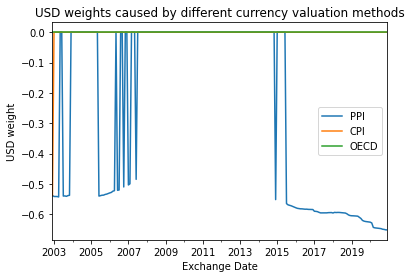

In [30]:
backtest_expensive_hedge_weights_ppi['USDCHF'].plot()
backtest_expensive_hedge_weights_cpi['USDCHF'].plot()
backtest_expensive_hedge_weights_oecd['USDCHF'].plot()
plt.title('USD weights caused by different currency valuation methods')
plt.ylabel('USD weight')
plt.legend(['PPI', 'CPI', 'OECD'])
#backtest_expensive_hedge_weights_check['USDCHF'].plot()

Compare now the actual relative USD valuations

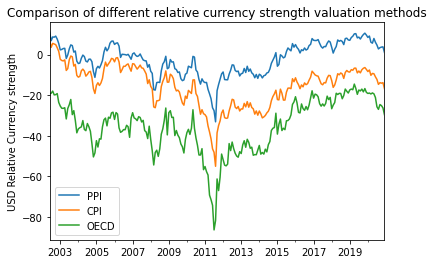

In [31]:
df_rel_currency_strength_ppi['USD'].plot()
df_rel_currency_strength_cpi['USD'].plot()
df_rel_currency_strength_oecd['USD'].plot()
plt.legend(['PPI', 'CPI', 'OECD'])
plt.ylabel('USD Relative Currency strength')
plt.title('Comparison of different relative currency strength valuation methods')
plt.savefig('Plots/ComparisonRelativeCurrencyStrengthUSD.jpg', dpi=300)

Second largest part of performance is comming from GBP. Lets also have a look at that:

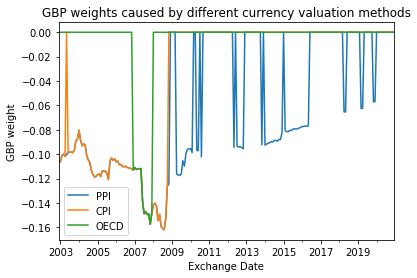

In [16]:
backtest_expensive_hedge_weights_ppi['GBPCHF'].plot()
backtest_expensive_hedge_weights_cpi['GBPCHF'].plot()
backtest_expensive_hedge_weights_oecd['GBPCHF'].plot()
plt.title('GBP weights caused by different currency valuation methods')
plt.ylabel('GBP weight')
plt.legend(['PPI', 'CPI', 'OECD'])

Text(0.5, 1.0, 'Comparison of different relative currency strength valuation methods')

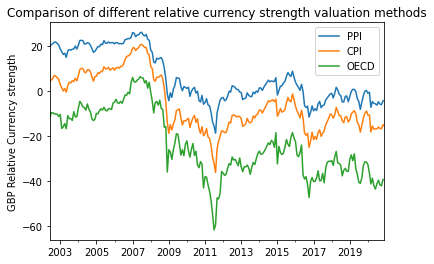

In [17]:
df_rel_currency_strength_ppi['GBP'].plot()
df_rel_currency_strength_cpi['GBP'].plot()
df_rel_currency_strength_oecd['GBP'].plot()
plt.legend(['PPI', 'CPI', 'OECD'])
plt.ylabel('GBP Relative Currency strength')
plt.title('Comparison of different relative currency strength valuation methods')

Comparison of CPI and PPI based relative currency strength. Subtract CPI from PPI, to visualize difference. PPI nearly always valuates the other currencies stronger than CPI, or put differently, valuates the CHF weaker.

<AxesSubplot:>

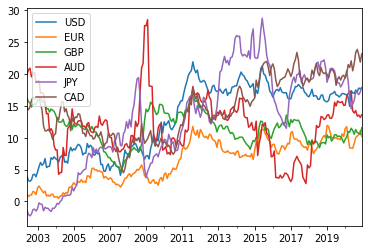

In [23]:
ppi_cpi_diff = df_rel_currency_strength_ppi.resample('M').last() - df_rel_currency_strength_cpi.resample('M').last()
ppi_cpi_diff.plot()